In [47]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/visualization_outputUp_2019_2024/SoilM_0_100cm/SoilM_0_100cm_20211122.png
/kaggle/input/visualization_outputUp_2019_2024/SoilM_0_100cm/SoilM_0_100cm_20231208.png
/kaggle/input/visualization_outputUp_2019_2024/SoilM_0_100cm/SoilM_0_100cm_20240724.png
/kaggle/input/visualization_outputUp_2019_2024/SoilM_0_100cm/SoilM_0_100cm_20201124.png
/kaggle/input/visualization_outputUp_2019_2024/SoilM_0_100cm/SoilM_0_100cm_20200922.png
/kaggle/input/visualization_outputUp_2019_2024/SoilM_0_100cm/SoilM_0_100cm_20230626.png
/kaggle/input/visualization_outputUp_2019_2024/SoilM_0_100cm/SoilM_0_100cm_20241115.png
/kaggle/input/visualization_outputUp_2019_2024/SoilM_0_100cm/SoilM_0_100cm_20220709.png
/kaggle/input/visualization_outputUp_2019_2024/SoilM_0_100cm/SoilM_0_100cm_20220625.png
/kaggle/input/visualization_outputUp_2019_2024/SoilM_0_100cm/SoilM_0_100cm_20220531.png
/kaggle/input/visualization_outputUp_2019_2024/SoilM_0_100cm/SoilM_0_100cm_20240909.png
/kaggle/input/visualization_outp

In [48]:
# Importation des bibliothèques nécessaires
import os
import glob
import re
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Conv2D, Conv3D, MaxPooling2D, MaxPooling3D
from tensorflow.keras.layers import Dense, Flatten, Reshape, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from datetime import datetime
import pickle
import gc  # Garbage Collector

In [49]:
# Configuration de la précision mixte pour optimiser la mémoire
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

# Vérification de la disponibilité du GPU
print("GPU disponible:", tf.config.list_physical_devices('GPU'))

GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [50]:
def setup_gpu():
    # Vérifier les GPU disponibles
    gpus = tf.config.list_physical_devices('GPU')
    print(f"GPU disponibles: {len(gpus)}")
    for gpu in gpus:
        print(f" - {gpu}")
    
    if len(gpus) == 0:
        print("Aucun GPU détecté!")
        return None
    
    # Configurer la croissance de mémoire pour éviter d'allouer toute la mémoire immédiatement
    for gpu in gpus:
        try:
            tf.config.experimental.set_memory_growth(gpu, True)
            print(f"Memory growth activé pour {gpu}")
        except RuntimeError as e:
            print(f"Erreur lors de la configuration de la mémoire pour {gpu}: {e}")
    
    # Activer la journalisation des opérations de distribution si nécessaire
    # os.environ["TF_CPP_MIN_LOG_LEVEL"] = "0"
    # tf.debugging.set_log_device_placement(True)
    
    # Créer une stratégie de distribution MirroredStrategy pour utiliser tous les GPU
    strategy = tf.distribute.MirroredStrategy()
    print(f"Nombre de périphériques dans la stratégie: {strategy.num_replicas_in_sync}")
    
    return strategy

In [51]:
strategy = setup_gpu()

GPU disponibles: 2
 - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
 - PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
Memory growth activé pour PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Memory growth activé pour PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
Nombre de périphériques dans la stratégie: 2


In [52]:
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

In [53]:
# Définition des chemins et constantes
DATA_DIR = '/kaggle/input/visualization_outputUp_2019_2024/PotEvap'
CHECKPOINT_DIR = '/kaggle/working/potevap_checkpoints'
MODEL_SAVE_PATH = os.path.join(CHECKPOINT_DIR, 'PotEvap_model')
SCALER_SAVE_PATH = os.path.join(CHECKPOINT_DIR, 'PotEvap_scaler.pkl')

# Création du répertoire de checkpoint s'il n'existe pas
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Paramètres du modèle
SEQUENCE_LENGTH = 30  # Nombre d'images consécutives à utiliser
IMG_HEIGHT = 128      # Hauteur redimensionnée (réduite pour économiser la mémoire)
IMG_WIDTH = 256       # Largeur redimensionnée
BATCH_SIZE = 32        # Batch size réduit pour économiser la mémoire
EPOCHS = 20           # Nombre d'époques d'entraînement

In [54]:
def extract_date_from_filename(filename):
    """Extract date from PotEvap filenames (ex: PotEvap_20190101.png)"""
    pattern = r'PotEvap_(\d{8})\.png'  # Changed from Rainf_/AvgSurfT_ to PotEvap_
    match = re.search(pattern, os.path.basename(filename))
    if match:
        date_str = match.group(1)
        return datetime.strptime(date_str, '%Y%m%d')
    return None
    
def optimize_memory():
    """Fonction pour libérer la mémoire"""
    gc.collect()
    tf.keras.backend.clear_session()

In [55]:
def load_and_preprocess_images(data_dir, img_height=128, img_width=256, max_images=None):
    # Récupérer tous les chemins d'images PotEvap
    image_files = glob.glob(os.path.join(data_dir, 'PotEvap_*.png'))  # Changed pattern
    print(f"Nombre total de fichiers PotEvap trouvés: {len(image_files)}")
    
    # ... rest of the function remains the same ...
    
    # Limiter le nombre de fichiers si spécifié
    if max_images is not None:
        image_files = image_files[:max_images]
        print(f"Utilisation des {len(image_files)} premiers fichiers")
    
    # Créer une liste de tuples (chemin_fichier, date)
    file_date_pairs = []
    for img_path in image_files:
        date = extract_date_from_filename(img_path)
        if date:
            file_date_pairs.append((img_path, date))
    
    # Trier par date
    file_date_pairs.sort(key=lambda x: x[1])
    print(f"Dates triées: de {file_date_pairs[0][1]} à {file_date_pairs[-1][1]}")
    
    # Charger et prétraiter les images par lots pour économiser la mémoire
    processed_images = []
    dates = []
    
    # Traitement par lots de 100 images
    batch_size = 100
    total_batches = (len(file_date_pairs) + batch_size - 1) // batch_size
    
    for batch_idx in range(total_batches):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, len(file_date_pairs))
        
        print(f"Traitement du lot {batch_idx+1}/{total_batches} ({start_idx}-{end_idx})...")
        
        batch_images = []
        batch_dates = []
        
        for img_path, date in file_date_pairs[start_idx:end_idx]:
            try:
                # Charger l'image avec plt.imread (optimisé pour PNG)
                img = plt.imread(img_path)
                
                # Convertir en niveaux de gris si nécessaire
                if len(img.shape) > 2 and img.shape[2] > 1:
                    img = np.mean(img, axis=2)
                
                # Redimensionner l'image (utiliser une taille plus petite économise la mémoire)
                img = tf.image.resize(img[:,:,np.newaxis], [img_height, img_width]).numpy()
                
                # Ajouter à notre lot
                batch_images.append(img)
                batch_dates.append(date)
                
            except Exception as e:
                print(f"Erreur de chargement de {img_path}: {e}")
        
        # Ajouter le lot traité à nos listes principales
        processed_images.extend(batch_images)
        dates.extend(batch_dates)
        
        # Libérer la mémoire
        gc.collect()
    
    # Convertir en array numpy
    X = np.array(processed_images)
    
    print(f"Forme finale des données: {X.shape}")
    return X, dates

In [56]:
# 1. First load the data
print("Chargement et prétraitement des images...")
X_images, dates = load_and_preprocess_images(
    DATA_DIR, 
    img_height=IMG_HEIGHT, 
    img_width=IMG_WIDTH,
    max_images=None
)

# 2. Then normalize the data
print("Normalisation des données...")
scaler = MinMaxScaler(feature_range=(0, 1))

# Reshape for scaling
X_reshaped = X_images.reshape(X_images.shape[0], -1)
X_scaled = scaler.fit_transform(X_reshaped)
X_images_scaled = X_scaled.reshape(X_images.shape)

Chargement et prétraitement des images...
Nombre total de fichiers PotEvap trouvés: 2191
Dates triées: de 2019-01-01 00:00:00 à 2024-12-31 00:00:00
Traitement du lot 1/22 (0-100)...
Traitement du lot 2/22 (100-200)...
Traitement du lot 3/22 (200-300)...
Traitement du lot 4/22 (300-400)...
Traitement du lot 5/22 (400-500)...
Traitement du lot 6/22 (500-600)...
Traitement du lot 7/22 (600-700)...
Traitement du lot 8/22 (700-800)...
Traitement du lot 9/22 (800-900)...
Traitement du lot 10/22 (900-1000)...
Traitement du lot 11/22 (1000-1100)...
Traitement du lot 12/22 (1100-1200)...
Traitement du lot 13/22 (1200-1300)...
Traitement du lot 14/22 (1300-1400)...
Traitement du lot 15/22 (1400-1500)...
Traitement du lot 16/22 (1500-1600)...
Traitement du lot 17/22 (1600-1700)...
Traitement du lot 18/22 (1700-1800)...
Traitement du lot 19/22 (1800-1900)...
Traitement du lot 20/22 (1900-2000)...
Traitement du lot 21/22 (2000-2100)...
Traitement du lot 22/22 (2100-2191)...
Forme finale des données

In [57]:
if test_files:
    test_file = test_files[0]
    print(f"Testing file: {test_file}")
    print(f"Extracted date: {extract_date_from_filename(test_file)}")

Testing file: /kaggle/input/visualization_outputUp_2019_2024/PotEvap/PotEvap_20190423.png
Extracted date: 2019-04-23 00:00:00


In [58]:
def date_to_features(date_obj):
    """Convertit une date en caractéristiques temporelles utilisables par le modèle"""
    # Vérifier si l'entrée est déjà un objet datetime
    if isinstance(date_obj, str):
        date = datetime.strptime(date_obj, '%Y-%m-%d')
    else:
        # Si c'est déjà un objet datetime, l'utiliser directement
        date = date_obj
    
    # Extraire les caractéristiques temporelles
    year = date.year
    month = date.month
    day = date.day
    day_of_year = date.timetuple().tm_yday
    
    # Caractéristiques cycliques pour le mois et le jour de l'année
    month_sin = np.sin(2 * np.pi * month / 12)
    month_cos = np.cos(2 * np.pi * month / 12)
    day_sin = np.sin(2 * np.pi * day_of_year / 365)
    day_cos = np.cos(2 * np.pi * day_of_year / 365)
    
    return np.array([year, month, day, day_of_year, month_sin, month_cos, day_sin, day_cos])

def create_sequences_with_dates(data, dates, seq_length=30, pred_steps=7, batch_size=100):
    """
    Créer des séquences pour l'entraînement de séries temporelles avec caractéristiques de date
    Utilise le traitement par lots pour économiser la mémoire
    
    Args:
        data: Array numpy des images prétraitées
        dates: Liste des dates correspondantes
        seq_length: Longueur de la séquence d'entrée
        pred_steps: Nombre de pas de temps à prédire
        batch_size: Taille des lots pour économiser la mémoire
        
    Returns:
        X: Séquences d'entrée
        y: Séquences cibles (à prédire)
        date_features: Caractéristiques de date pour chaque séquence
    """
    total_sequences = len(data) - seq_length - pred_steps + 1
    print(f"Création de {total_sequences} séquences au total...")
    
    # Préallouer les tableaux pour économiser de la mémoire
    X = np.zeros((total_sequences, seq_length, *data.shape[1:]), dtype=np.float32)
    y = np.zeros((total_sequences, pred_steps, *data.shape[1:]), dtype=np.float32)
    date_features = np.zeros((total_sequences, 8), dtype=np.float32)  # 8 caractéristiques de date
    
    # Traitement par lots pour économiser la mémoire
    for start_idx in range(0, total_sequences, batch_size):
        end_idx = min(start_idx + batch_size, total_sequences)
        print(f"Traitement des séquences {start_idx} à {end_idx}...", end="\r")
        
        for i in range(start_idx, end_idx):
            # Séquence d'entrée: seq_length images consécutives
            X[i] = data[i:i+seq_length]
            # Séquence cible: pred_steps images suivantes
            y[i] = data[i+seq_length:i+seq_length+pred_steps]
            # Caractéristiques de date pour la dernière date de la séquence d'entrée
            last_date = dates[i+seq_length-1]
            date_features[i] = date_to_features(last_date)
        
        # Libérer la mémoire régulièrement
        if (end_idx - start_idx) % (batch_size * 5) == 0:
            gc.collect()
    
    print(f"\nNombre de séquences créées: {total_sequences}")
    
    
    return X, y, date_features



In [59]:
PREDICTION_STEPS=7
# Création des séquences avec caractéristiques de date
print("Création des séquences d'entraînement avec caractéristiques de date...")
X_seq, y_seq, date_features = create_sequences_with_dates(
    X_images_scaled, dates, SEQUENCE_LENGTH, PREDICTION_STEPS)

# Afficher les dimensions
print(f"Forme des séquences X: {X_seq.shape}")
print(f"Forme des séquences y: {y_seq.shape}")
print(f"Forme des caractéristiques de date: {date_features.shape}")

# Libérer de la mémoire
try:
    del X_images, X_reshaped, X_scaled
except NameError:
    print("Certaines variables à supprimer n'existent pas, poursuite du processus...")
optimize_memory()
optimize_memory()

# Division en ensembles d'entraînement et de validation (80/20)
split_idx = int(len(X_seq) * 0.8)
X_train, X_val = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_val = y_seq[:split_idx], y_seq[split_idx:]
date_features_train, date_features_val = date_features[:split_idx], date_features[split_idx:]

print(f"Ensemble d'entraînement: {X_train.shape[0]} séquences")
print(f"Ensemble de validation: {X_val.shape[0]} séquences")

# Libérer encore de la mémoire
try:
    del X_images, X_reshaped, X_scaled
except NameError:
    print("Certaines variables à supprimer n'existent pas, poursuite du processus...")
optimize_memory()

# Afficher quelques statistiques sur les caractéristiques de date
print("\nStatistiques des caractéristiques de date (ensemble d'entraînement):")
print(f"Années: min={date_features_train[:, 0].min()}, max={date_features_train[:, 0].max()}")
print(f"Mois: min={date_features_train[:, 1].min()}, max={date_features_train[:, 1].max()}")

Création des séquences d'entraînement avec caractéristiques de date...
Création de 2155 séquences au total...
Traitement des séquences 2100 à 2155...
Nombre de séquences créées: 2155
Forme des séquences X: (2155, 30, 128, 256, 1)
Forme des séquences y: (2155, 7, 128, 256, 1)
Forme des caractéristiques de date: (2155, 8)
Ensemble d'entraînement: 1724 séquences
Ensemble de validation: 431 séquences
Certaines variables à supprimer n'existent pas, poursuite du processus...

Statistiques des caractéristiques de date (ensemble d'entraînement):
Années: min=2019.0, max=2023.0
Mois: min=1.0, max=12.0


Chargement et prétraitement des images...
Nombre total de fichiers PotEvap trouvés: 2191
Utilisation des 730 premiers fichiers
Dates triées: de 2019-01-05 00:00:00 à 2024-12-31 00:00:00
Traitement du lot 1/8 (0-100)...
Traitement du lot 2/8 (100-200)...
Traitement du lot 3/8 (200-300)...
Traitement du lot 4/8 (300-400)...
Traitement du lot 5/8 (400-500)...
Traitement du lot 6/8 (500-600)...
Traitement du lot 7/8 (600-700)...
Traitement du lot 8/8 (700-730)...
Forme finale des données: (730, 128, 256, 1)
Nombre d'images chargées: 730
Forme des images: (730, 128, 256, 1)
Première date: 2019-01-05 00:00:00
Dernière date: 2024-12-31 00:00:00


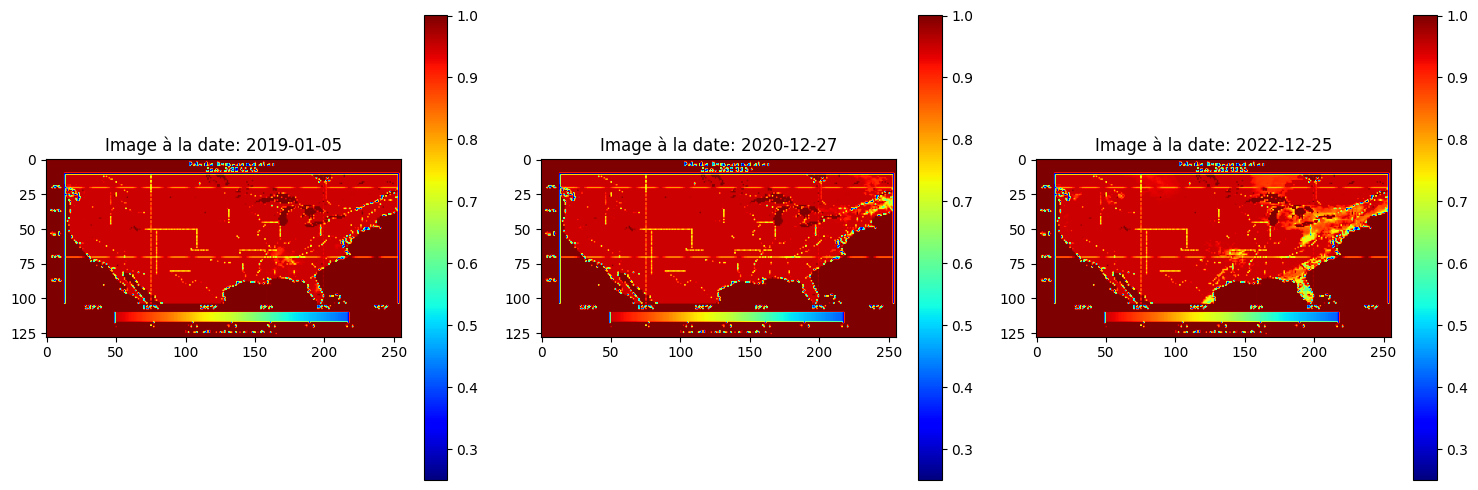

In [60]:
# Exécuter le chargement des données
print("Chargement et prétraitement des images...")
X_images, dates = load_and_preprocess_images(
    DATA_DIR, 
    img_height=IMG_HEIGHT, 
    img_width=IMG_WIDTH,
    max_images=730  # Environ 2 ans de données - ajustez selon vos besoins
)

# Afficher quelques informations
print(f"Nombre d'images chargées: {len(X_images)}")
print(f"Forme des images: {X_images.shape}")
print(f"Première date: {dates[0]}")
print(f"Dernière date: {dates[-1]}")

# Visualiser quelques exemples d'images
plt.figure(figsize=(15, 5))
for i in range(3):  # Afficher 3 images
    idx = i * (len(X_images) // 3)  # Prendre des images réparties uniformément
    plt.subplot(1, 3, i+1)
    plt.imshow(X_images[idx, :, :, 0], cmap='jet')
    plt.title(f"Image à la date: {dates[idx].strftime('%Y-%m-%d')}")
    plt.colorbar()
plt.tight_layout()
plt.show()

# Libérer de la mémoire
optimize_memory()

In [61]:
# Réduire la taille du batch pour économiser la mémoire
BATCH_SIZE = 4 * strategy.num_replicas_in_sync
SEQUENCE_LENGTH = 30  # Votre séquence a une longueur de 30

def build_lightweight_seq_model(seq_length, img_height, img_width, date_features_dim=8):
    """
    Construit un modèle léger qui accepte des séquences
    """
    # Entrée pour la séquence d'images
    seq_input = Input(shape=(seq_length, img_height, img_width, 1), name='seq_input')
    
    # Entrée pour les caractéristiques de date
    date_input = Input(shape=(date_features_dim,), name='date_input')
    
    # Pour chaque image de la séquence, nous allons extraire des caractéristiques
    # Nous utiliserons la dernière image de la séquence pour la prédiction
    last_frame = seq_input[:, -1]  # Prendre la dernière image de la séquence
    
    # Traitement de l'image avec un CNN léger
    # Niveau 1
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(last_frame)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    # Niveau 2
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # Niveau 3
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
    
    # Extraction des caractéristiques globales de l'image
    global_img = tf.keras.layers.GlobalAveragePooling2D()(conv3)
    
    # Traitement des caractéristiques de date
    date_dense = Dense(32, activation='relu')(date_input)
    
    # Concaténer avec les caractéristiques de date
    concat_features = Concatenate()([global_img, date_dense])
    
    # Fusion des caractéristiques
    combined = Dense(64, activation='relu')(concat_features)
    combined = Dense(128, activation='relu')(combined)
    combined = Dense((img_height//4) * (img_width//4), activation='relu')(combined)
    combined = Reshape((img_height//4, img_width//4, 1))(combined)
    
    # Décodeur
    up1 = Conv2D(32, (3, 3), activation='relu', padding='same')(UpSampling2D(size=(2, 2))(combined))
    up2 = Conv2D(16, (3, 3), activation='relu', padding='same')(UpSampling2D(size=(2, 2))(up1))
    
    # Couche de sortie
    output = Conv2D(1, (1, 1), activation='sigmoid')(up2)
    
    model = Model(inputs=[seq_input, date_input], outputs=output)
    
    return model

In [62]:

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import Flatten, Reshape, Concatenate, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from datetime import datetime, timedelta
from tensorflow.keras.models import Model

# Création et compilation du modèle avec la stratégie multi-GPU
with strategy.scope():
    # Création du modèle
    print("Création du modèle léger compatibles avec les séquences...")
    model = build_lightweight_seq_model(SEQUENCE_LENGTH, IMG_HEIGHT, IMG_WIDTH)
    
    # Compilation du modèle
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    
    # Callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss', 
            patience=5, 
            verbose=1, 
            restore_best_weights=True
        ),
        ReduceLROnPlateau(
            monitor='val_loss', 
            factor=0.5, 
            patience=3, 
            verbose=1
        ),
        ModelCheckpoint(
            filepath=os.path.join(CHECKPOINT_DIR, 'PotEvap_lightweight_model.keras'),
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        )
    ]

# Afficher le résumé du modèle
model.summary()



Création du modèle léger compatibles avec les séquences...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ seq_input (InputLayer)    │ (None, 30, 128, 256,   │              0 │ -                      │
│                           │ 1)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 128, 256, 1)    │              0 │ seq_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 256, 16)   │            160 │ get_item[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 128, 16)    │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 64, 128, 32)    │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 64, 32)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 64, 64)     │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ date_input (InputLayer)   │ (None, 8)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 64)             │              0 │ conv2d_2[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 32)             │            288 │ date_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 96)             │              0 │ global_average_poolin… │
│                           │                        │                │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │          6,208 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 128)            │          8,320 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 2048)           │        264,192 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 32, 64, 1)      │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 64, 128, 1)     │              0 │ reshape[0][0]          │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)    

 Total params: 307,265 (1.17 MB)

 Trainable params: 307,265 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

Début de l'entraînement...
Epoch 1/20


I0000 00:00:1745781347.353468      99 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1745781347.675246      97 cuda_dnn.cc:529] Loaded cuDNN version 90300


216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1504 - mae: 0.2932
Epoch 1: val_loss improved from inf to 0.05857, saving model to /kaggle/working/potevap_checkpoints/PotEvap_lightweight_model.keras
216/216 ━━━━━━━━━━━━━━━━━━━━ 21s 64ms/step - loss: 0.1501 - mae: 0.2928 - val_loss: 0.0586 - val_mae: 0.1204 - learning_rate: 0.0010
Epoch 2/20
214/216 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0626 - mae: 0.1304
Epoch 2: val_loss improved from 0.05857 to 0.04804, saving model to /kaggle/working/potevap_checkpoints/PotEvap_lightweight_model.keras
216/216 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.0625 - mae: 0.1303 - val_loss: 0.0480 - val_mae: 0.1156 - learning_rate: 0.0010
Epoch 3/20
214/216 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0532 - mae: 0.1173
Epoch 3: val_loss improved from 0.04804 to 0.04325, saving model to /kaggle/working/potevap_checkpoints/PotEvap_lightweight_model.keras
216/216 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.0531 - mae: 0.1173 - val_loss: 0.0433 - val_

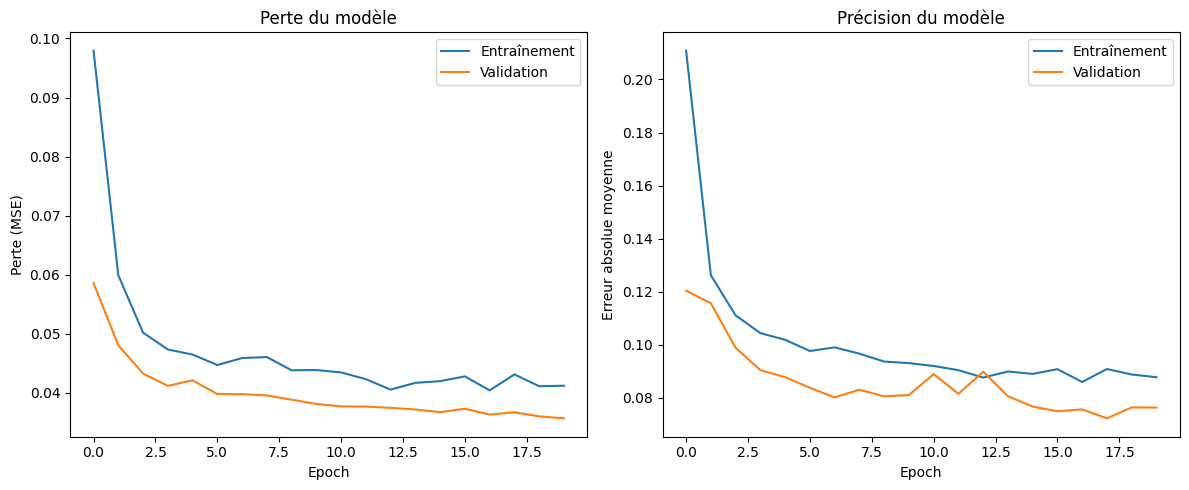

In [63]:
# Entraînement du modèle
print("Début de l'entraînement...")
history = model.fit(
    [X_train, date_features_train], y_train[:, 0],  # Prédire seulement la première image cible
    validation_data=([X_val, date_features_val], y_val[:, 0]),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

# Libérer de la mémoire
gc.collect()
tf.keras.backend.clear_session()

# Sauvegarder l'historique d'entraînement
hist_df = pd.DataFrame(history.history)
hist_csv_file = os.path.join(CHECKPOINT_DIR, 'history_potevap.csv')
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

print(f"Historique d'entraînement sauvegardé à: {hist_csv_file}")

# Visualisation des courbes d'apprentissage
plt.figure(figsize=(12, 5))

# Courbe de perte
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Perte du modèle')
plt.ylabel('Perte (MSE)')
plt.xlabel('Epoch')
plt.legend(['Entraînement', 'Validation'], loc='upper right')

# Courbe de précision (MAE) 
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Précision du modèle')
plt.ylabel('Erreur absolue moyenne')
plt.xlabel('Epoch')
plt.legend(['Entraînement', 'Validation'], loc='upper right')

plt.tight_layout()
plt.savefig(os.path.join(CHECKPOINT_DIR, 'learning_curves_avgsurft.png'))
plt.show()

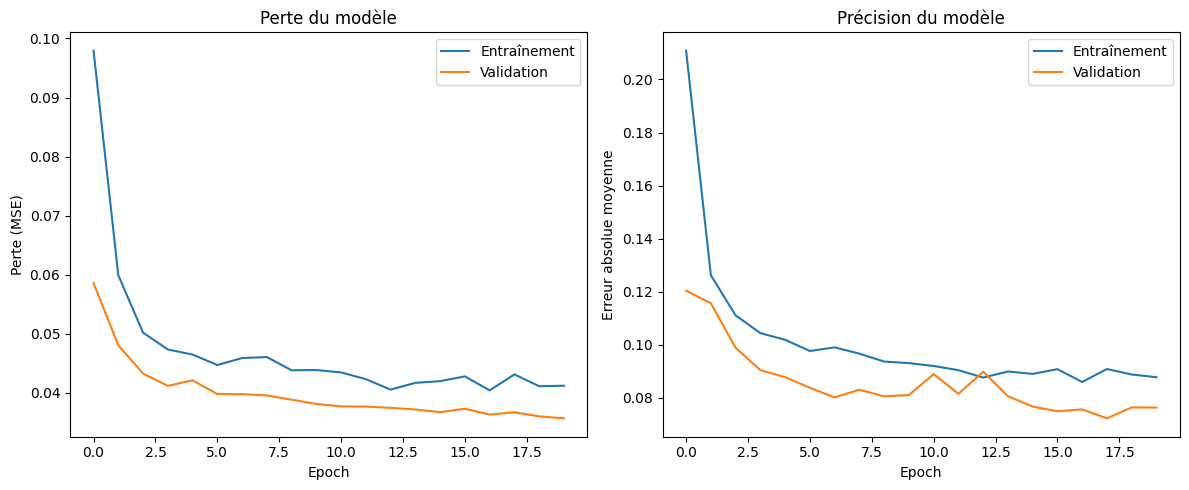

In [69]:
# Visualisation des courbes d'apprentissage
plt.figure(figsize=(12, 5))

# Courbe de perte
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Perte du modèle')
plt.ylabel('Perte (MSE)')
plt.xlabel('Epoch')
plt.legend(['Entraînement', 'Validation'], loc='upper right')

# Courbe de précision (MAE)
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Précision du modèle')
plt.ylabel('Erreur absolue moyenne')
plt.xlabel('Epoch')
plt.legend(['Entraînement', 'Validation'], loc='upper right')
os.makedirs('models', exist_ok=True)  # Crée le dossier 'models' si besoin

plt.tight_layout()
plt.savefig('models/learning_curves_potevap.png')
plt.show()

In [65]:
def predict_map_for_date(model, target_date, scaler, img_height=128, img_width=256):
    """
    Prédit une carte pour une date spécifique
    """
    # Convertir la date en caractéristiques
    date = datetime.strptime(target_date, '%Y-%m-%d')
    day_of_year = date.timetuple().tm_yday
    month = date.month
    year = date.year
    
    # Créer les caractéristiques de date complètes (8 dimensions)
    day_of_week = date.weekday()
    week_of_year = date.isocalendar()[1]
    quarter = (month - 1) // 3 + 1
    is_weekend = 1 if day_of_week >= 5 else 0
    season = (month % 12 + 3) // 3
    
    # Créer le vecteur de caractéristiques complet avec 8 dimensions
    date_features = np.array([[day_of_year, month, year, day_of_week, week_of_year, quarter, is_weekend, season]])
    
    # Créer une image factice (dummy) avec la bonne forme
    dummy_img = np.zeros((1, 30, img_height, img_width, 1))
    
    # Faire la prédiction
    predicted_map_scaled = model.predict([dummy_img, date_features], verbose=0)
    
    # Correction: Traiter correctement la forme pour l'inverse_transform
    # Obtenir la forme originale avant de redimensionner
    original_shape = predicted_map_scaled.shape
    
    # Aplatir complètement le tableau pour l'inverse_transform
    flattened = predicted_map_scaled.flatten().reshape(-1, 1)
    
    # Appliquer l'inverse_transform
    predicted_map_values = scaler.inverse_transform(flattened)
    
    # Remettre en forme de carte
    return predicted_map_values.reshape(img_height, img_width)

Calcul de l'exactitude du modèle sur l'ensemble de validation...
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
Exactitude du modèle (seuil d'erreur = 0.0974):
  80.83% des prédictions ont une erreur < seuil


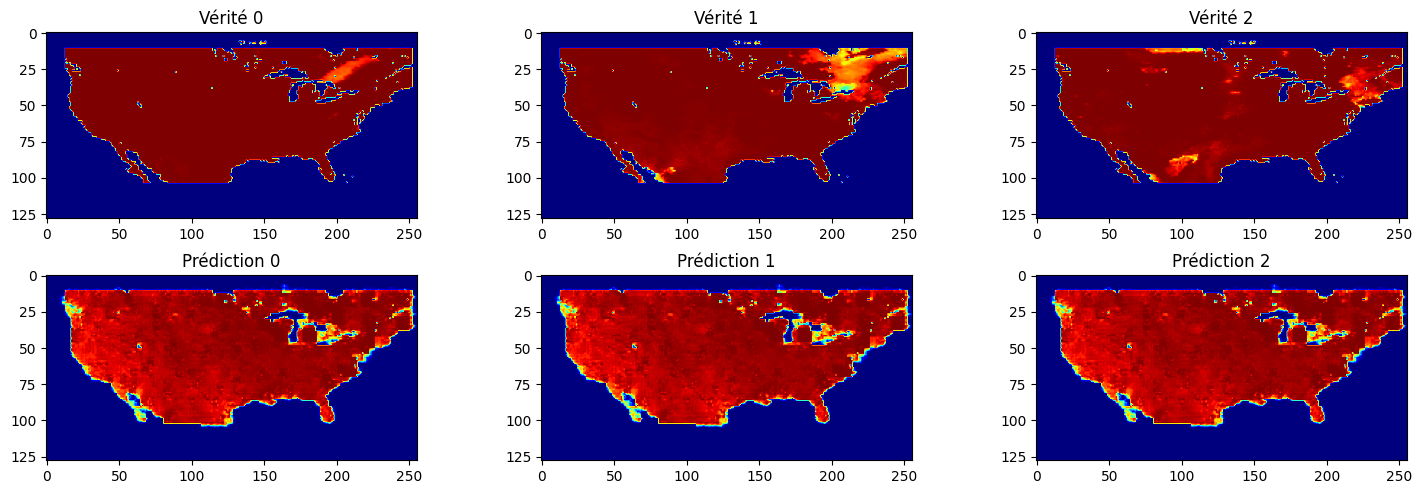

In [67]:
print("Calcul de l'exactitude du modèle sur l'ensemble de validation...")

# 1. Get predictions
y_pred = model.predict([X_val, date_features_val], batch_size=BATCH_SIZE, verbose=1)

# 2. Compare only first frame
y_val_first_frame = y_val[:, 0, :, :, :]  # Shape (431, 128, 256, 1)

# 3. Calculate threshold (using first frame only)
threshold = 0.2 * np.std(y_val_first_frame)

# 4. Calculate accuracy
errors = np.abs(y_pred - y_val_first_frame)
accuracy = np.mean(errors < threshold) * 100

print(f"Exactitude du modèle (seuil d'erreur = {threshold:.4f}):")
print(f"  {accuracy:.2f}% des prédictions ont une erreur < seuil")

# 5. Visualization (example for first 3 samples)
plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(2, 3, i+1)
    plt.imshow(y_val_first_frame[i, ..., 0], cmap='jet')
    plt.title(f"Vérité {i}")
    plt.subplot(2, 3, i+4)
    plt.imshow(y_pred[i, ..., 0], cmap='jet')
    plt.title(f"Prédiction {i}")
plt.tight_layout()
plt.show()


Évaluation du modèle PotEvap sur l'ensemble de validation...
Mode: Prédiction de la première frame seulement
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0283 - mae: 0.0633

Métriques d'évaluation:
  Loss (MSE): 0.0336
  MAE: 0.0744

Analyse détaillée des prédictions...
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step

Exactitude (erreur < 0.0974): 80.83%


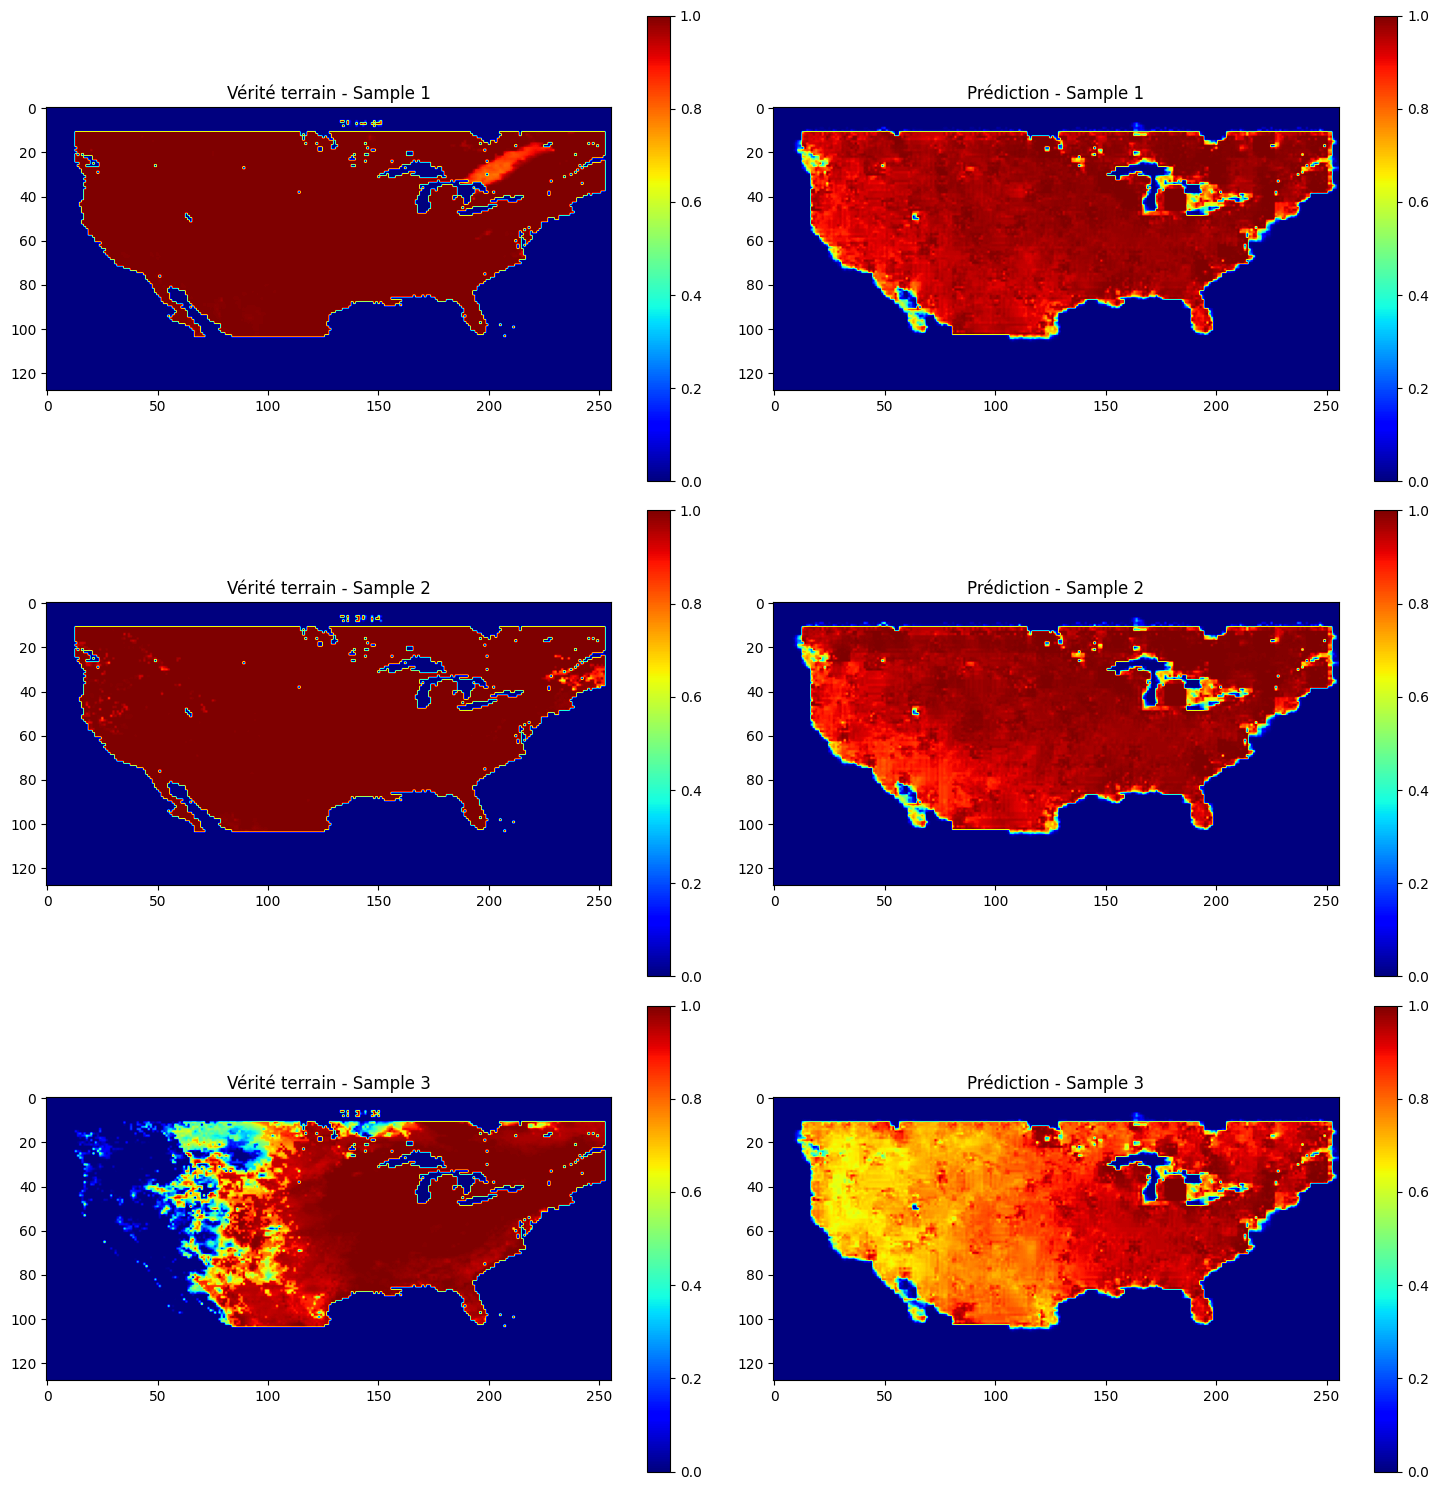

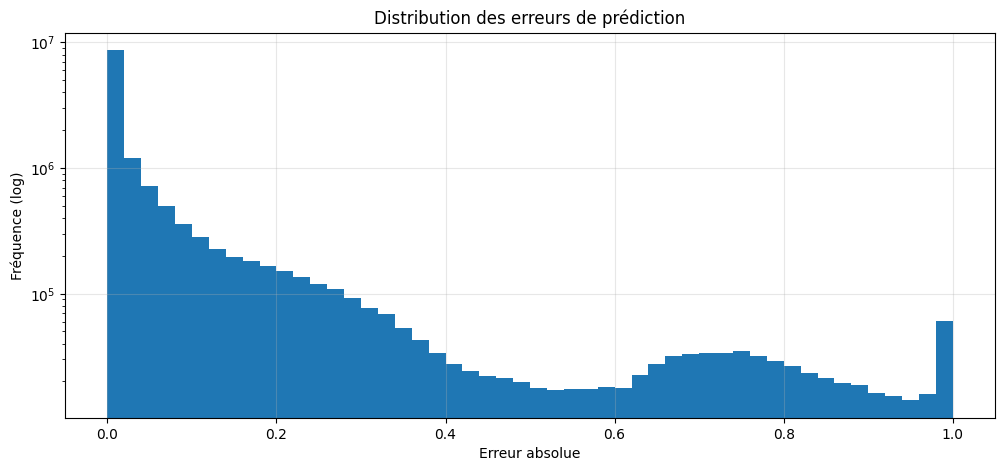

In [73]:
# EVALUATION ONLY CODE FOR POTEVAP MODEL
print("\nÉvaluation du modèle PotEvap sur l'ensemble de validation...")

# Determine if model predicts single frame or sequence
predicts_single_frame = (len(model.output_shape) == 4)  # (batch, h, w, channels)

# Prepare validation targets accordingly
if predicts_single_frame:
    y_val_target = y_val[:, 0]  # Use only first frame
    print("Mode: Prédiction de la première frame seulement")
else:
    y_val_target = y_val  # Use full sequence
    print("Mode: Prédiction de séquence complète")

# 1. Standard Evaluation Metrics
eval_results = model.evaluate(
    [X_val, date_features_val], 
    y_val_target,
    batch_size=BATCH_SIZE,
    verbose=1
)

print("\nMétriques d'évaluation:")
print(f"  Loss (MSE): {eval_results[0]:.4f}")
print(f"  MAE: {eval_results[1]:.4f}")

# 2. Detailed Prediction Analysis
print("\nAnalyse détaillée des prédictions...")
y_pred = model.predict([X_val, date_features_val], batch_size=BATCH_SIZE)

# Calculate threshold-based accuracy
threshold = 0.2 * np.std(y_val_target)
errors = np.abs(y_pred - y_val_target)
accuracy = np.mean(errors < threshold) * 100

print(f"\nExactitude (erreur < {threshold:.4f}): {accuracy:.2f}%")

# 3. Visualize Sample Predictions
def visualize_predictions(y_true, y_pred, num_samples=3):
    plt.figure(figsize=(15, 5*num_samples))
    for i in range(num_samples):
        idx = i * len(y_true) // num_samples  # Spread samples across dataset
        
        plt.subplot(num_samples, 2, 2*i+1)
        plt.imshow(y_true[idx].squeeze(), cmap='jet', vmin=0, vmax=1)
        plt.title(f"Vérité terrain - Sample {i+1}")
        plt.colorbar()
        
        plt.subplot(num_samples, 2, 2*i+2)
        plt.imshow(y_pred[idx].squeeze(), cmap='jet', vmin=0, vmax=1)
        plt.title(f"Prédiction - Sample {i+1}")
        plt.colorbar()
    plt.tight_layout()
    plt.show()

visualize_predictions(y_val_target, y_pred)

# 4. Error Distribution Analysis
plt.figure(figsize=(12, 5))
plt.hist(errors.flatten(), bins=50, log=True)
plt.title("Distribution des erreurs de prédiction")
plt.xlabel("Erreur absolue")
plt.ylabel("Fréquence (log)")
plt.grid(True, alpha=0.3)
plt.show()

# 5. Temporal Error Analysis (if predicting sequences)
if not predicts_single_frame:
    print("\nAnalyse temporelle par frame:")
    frame_errors = [np.mean(np.abs(y_pred[:,i] - y_val[:,i])) for i in range(y_val.shape[1])]
    
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, len(frame_errors)+1), frame_errors, 'o-')
    plt.title("MAE par frame dans la séquence")
    plt.xlabel("Position dans la séquence")
    plt.ylabel("MAE")
    plt.grid(True)
    plt.show()